# Major Project : Tarun Raj Singh (B21CS076) and Aryan Himmatlal Prajapati (B21EE012)

<h3> (PROJECT 3) TOPIC : BRAIN STROKE PREDICTION </h3>

In [124]:
# Importing Necessary Libraries and Modules

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import lightgbm
from sklearn.metrics import confusion_matrix as cm 
from sklearn.metrics import f1_score as f1
from sklearn.metrics import recall_score as rs 
from sklearn.metrics import  precision_score as ps 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score as acc

In [125]:
import warnings
warnings.filterwarnings('ignore')

In [126]:
# Importing and Reading dataset into Pandas DataFrame

df = pd.read_csv("brain_stroke.csv")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


<h2> PRE-PROCESSING </h2>

In [127]:
# Checking Correlation between features and Classes

df.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.278120,0.264852,0.236763,0.373703,0.246478
hypertension,0.278120,1.000000,0.111974,0.170028,0.158762,0.131965
heart_disease,0.264852,0.111974,1.000000,0.166847,0.060926,0.134610
avg_glucose_level,0.236763,0.170028,0.166847,1.000000,0.186348,0.133227
bmi,0.373703,0.158762,0.060926,0.186348,1.000000,0.056926
stroke,0.246478,0.131965,0.134610,0.133227,0.056926,1.000000


Got no relevant correlations , which can seperate out some features. Since, the dimension of data is not too large , hence using entire feature set for training the models.  

In [128]:
# Checking data type of all available features.

for column in df.columns:
    print("For Column ( ",column," ) Data Type : ",df[column].dtype)

For Column (  gender  ) Data Type :  object
For Column (  age  ) Data Type :  float64
For Column (  hypertension  ) Data Type :  int64
For Column (  heart_disease  ) Data Type :  int64
For Column (  ever_married  ) Data Type :  object
For Column (  work_type  ) Data Type :  object
For Column (  Residence_type  ) Data Type :  object
For Column (  avg_glucose_level  ) Data Type :  float64
For Column (  bmi  ) Data Type :  float64
For Column (  smoking_status  ) Data Type :  object
For Column (  stroke  ) Data Type :  int64


In [129]:
# Normalizing / scaling the attributes using maximum absolute scaling

def scale_normalize(df):
  for column in df.columns:
    if df[column].dtype == float:
        df[column] = (df[column])/(df[column].max())
  return df

df = scale_normalize(df)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,0.817073,0,1,Yes,Private,Urban,0.841577,0.748466,formerly smoked,1
1,Male,0.975610,0,1,Yes,Private,Rural,0.389784,0.664622,never smoked,1
2,Female,0.597561,0,0,Yes,Private,Urban,0.630124,0.703476,smokes,1
3,Female,0.963415,1,0,Yes,Self-employed,Rural,0.640760,0.490798,never smoked,1
4,Male,0.987805,0,0,Yes,Private,Urban,0.685251,0.593047,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,0.500000,0,0,No,Private,Rural,0.258151,0.609407,formerly smoked,0
4977,Male,0.487805,0,0,Yes,Private,Urban,0.703430,0.635992,smokes,0
4978,Female,0.548780,1,0,Yes,Govt_job,Rural,0.349672,0.650307,smokes,0
4979,Male,0.487805,0,0,Yes,Private,Rural,0.308898,0.613497,smokes,0


In [130]:
# Checking unique values in object type features 

def check_unique(df):
    for column in df.columns:
        if df[column].dtype == object:
            x = np.unique(df[column])
            print("Unique Values for " , column , " are : " , x)

check_unique(df)

Unique Values for  gender  are :  ['Female' 'Male']
Unique Values for  ever_married  are :  ['No' 'Yes']
Unique Values for  work_type  are :  ['Govt_job' 'Private' 'Self-employed' 'children']
Unique Values for  Residence_type  are :  ['Rural' 'Urban']
Unique Values for  smoking_status  are :  ['Unknown' 'formerly smoked' 'never smoked' 'smokes']


For the column smoking_status we have some entries as Unknown ( which means the value for this cell is not available ) , we will replace them with the mode of the column.

In [131]:
# Finding the mode of the feature ( smoking_status )
df['smoking_status'].value_counts()

never smoked       1838
Unknown            1500
formerly smoked     867
smokes              776
Name: smoking_status, dtype: int64

Therefore , mode of the data is 'never smoked'

In [132]:
# Replacing the Unknown values with the feature mode
df['smoking_status'] = df['smoking_status'].replace(to_replace='Unknown',value='never smoked')

In [133]:
# Let's check where are the null values and how many total null values are there in each column and in total
cnt = 0
for column in df.columns :
  miss_val = df[column].isnull().sum()
  cnt+=miss_val
  print("Number of Null values in column ( " , column , " )  = " , df[column].isnull().sum())
print("")
print("Total Number of missing values are : ",cnt)

Number of Null values in column (  gender  )  =  0
Number of Null values in column (  age  )  =  0
Number of Null values in column (  hypertension  )  =  0
Number of Null values in column (  heart_disease  )  =  0
Number of Null values in column (  ever_married  )  =  0
Number of Null values in column (  work_type  )  =  0
Number of Null values in column (  Residence_type  )  =  0
Number of Null values in column (  avg_glucose_level  )  =  0
Number of Null values in column (  bmi  )  =  0
Number of Null values in column (  smoking_status  )  =  0
Number of Null values in column (  stroke  )  =  0

Total Number of missing values are :  0


Hence, there are no null Values, so we can now , categorically encode the features.

In [134]:
# function to categorically encode the object type features

def categorical(df):
  df3 = df.copy()
  columns = []
  for i in df3.columns:
    columns.append(i)

  for x in columns:
    if df3[x].dtype == object:
      dic = {}
      cnt = 0
      l = len(df[x])
      for i in range(0,l):
        temp = df3[x][i]
        if temp not in dic:
          dic[temp] = cnt
          cnt+=1
      df3[x] = df3[x].replace(dic)
  return df3

In [135]:
df = categorical(df)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,0.817073,0,1,0,0,0,0.841577,0.748466,0,1
1,0,0.975610,0,1,0,0,1,0.389784,0.664622,1,1
2,1,0.597561,0,0,0,0,0,0.630124,0.703476,2,1
3,1,0.963415,1,0,0,1,1,0.640760,0.490798,1,1
4,0,0.987805,0,0,0,0,0,0.685251,0.593047,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,0,0.500000,0,0,1,0,1,0.258151,0.609407,0,0
4977,0,0.487805,0,0,0,0,0,0.703430,0.635992,2,0
4978,1,0.548780,1,0,0,2,1,0.349672,0.650307,2,0
4979,0,0.487805,0,0,0,0,1,0.308898,0.613497,2,0


In [136]:
# Checking Number of Instances in each class 
num0 = df['stroke'].value_counts()
print("Number of Instances of Class 0 ( No stroke ) : ",num0[0])
print("Number of Instances of Class 1 ( Stroke )     : ",num0[1])
print("_______________________________________________________")
print("Highly Imbalanced by ratio : " ,num0[0]/num0[1])

Number of Instances of Class 0 ( No stroke ) :  4733
Number of Instances of Class 1 ( Stroke )     :  248
_______________________________________________________
Highly Imbalanced by ratio :  19.08467741935484


<h5> Hence we can see that the dataset is highly Imbalanced as Instances in Class 0 >>>> Instances in Class 1 </h5>

Text(0.5, 4000, 'High instances')

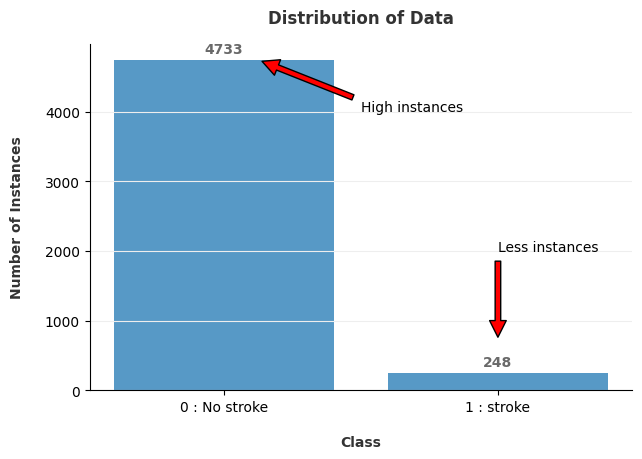

In [137]:
# Visualizing the Distribution of data by number of Instances in each class using a Bar plot

x = ["0 : No stroke","1 : stroke"]
fig, ax = plt.subplots(figsize=(7,4.50))
bars = ax.bar([0,1],num0,tick_label=x,alpha=0.75)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, color='#EEEEEE')

bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 100,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color="dimgrey",
      weight='bold'
  )

ax.set_xlabel('Class', labelpad=15, color='#333333',weight='bold')
ax.set_ylabel('Number of Instances', labelpad=15, color='#333333',weight='bold')
ax.set_title('Distribution of Data', pad=15, color='#333333',
             weight='bold')
low_point  = (1,700)
high_point = (0.12,4750)
plt.annotate('Less instances', xy=low_point, xytext=(1,2000),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('High instances', xy=high_point, xytext=(0.5, 4000),
            arrowprops=dict(facecolor='red', shrink=0.05))

# If we apply any classifier Algorithm on this imbalanced dataset :

<h3> Using Adaboost </h3>

In [138]:
# Seperating out Features and labels
x_data = df.drop(columns=['stroke'])
y_data = df['stroke']

In [139]:
# Splitting into training and testing features and labels
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,random_state = 100,stratify = y_data)

In [140]:
# Creating Adaboost Object

Ada_clf = AdaBoostClassifier(random_state=42)
Ada_clf.fit(x_train,y_train)

AdaBoostClassifier(random_state=42)

In [141]:
# Predicting the test data outcomes
y_preds = Ada_clf.predict(x_test)

In [142]:
# Checking the Classification report 
class_names = ["0 : No Stroke","1 : Stroke"]
print(classification_report(y_true=y_test,y_pred=y_preds,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       0.95      1.00      0.97      1184
   1 : Stroke       0.17      0.02      0.03        62

     accuracy                           0.95      1246
    macro avg       0.56      0.51      0.50      1246
 weighted avg       0.91      0.95      0.93      1246



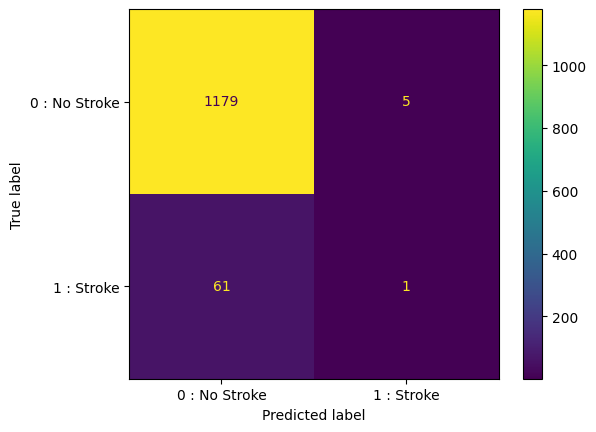

In [143]:
# Plotting the Confusion Matrix for Imbalanced Data and AdaBoost
cf_mat_ada_imb = cm(y_test,y_preds,labels=[0,1])
disp_ada_imb = ConfusionMatrixDisplay(confusion_matrix=cf_mat_ada_imb,display_labels=["0 : No Stroke","1 : Stroke"])
disp_ada_imb.plot()

<h5> From the confusion matrix it is clear that the model is very poorly performing for the Class 1 (Stroke) instances , due to the highly Imbalance in the data . </h5>

<h3> Using XGBoost </h3>

In [144]:
# Creating XGBboost Object 

XGB_clf = XGBClassifier(random_state=42)
XGB_clf.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [145]:
# Predicting the test data outcomes
y_preds_xgb = XGB_clf.predict(x_test)

In [146]:
# Checking the Classification report 
print(classification_report(y_true=y_test,y_pred=y_preds_xgb,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       0.95      0.99      0.97      1184
   1 : Stroke       0.14      0.03      0.05        62

     accuracy                           0.94      1246
    macro avg       0.55      0.51      0.51      1246
 weighted avg       0.91      0.94      0.92      1246



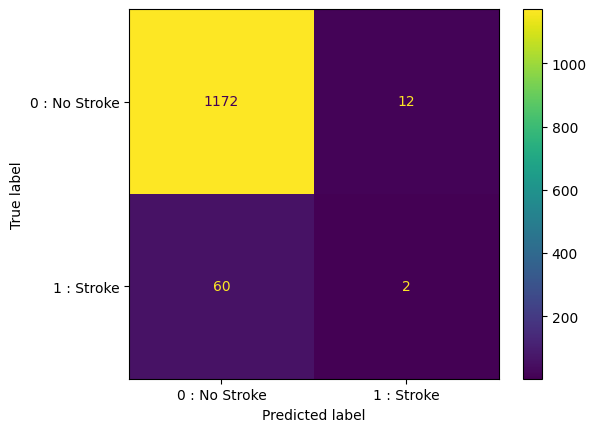

In [147]:
# Plotting the Confusion Matrix for Imbalanced Data and XGBoost
cf_mat_xgb_imb = cm(y_test,y_preds_xgb,labels=[0,1])
disp_xgb_imb = ConfusionMatrixDisplay(confusion_matrix=cf_mat_xgb_imb,display_labels=["0 : No Stroke","1 : Stroke"])
disp_xgb_imb.plot()


<h5> Here also we can clearly see from the confusion matrix that the model is very poor in classifying the class 1 ( Stroke ) Instances </h5>

<h3> Using LGBM </h3>

In [148]:
# Making LGBM data (Imbalanced)
params = {'num_leaves':50}
train_data_imb = lightgbm.Dataset(x_train,label=y_train)
test_data_imb = lightgbm.Dataset(x_test,label=y_test)

In [149]:
# Trainign LGBM model on Imbalanced data
LGBM_imb = lightgbm.train(params,train_data_imb)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 3735, number of used features: 10
[LightGBM] [Info] Start training from score 0.049799


In [150]:
# Predicting the results for Testing set
LGBM_preds = LGBM_imb.predict(x_test)

In [151]:
# Converting Predictions to the nearest class labels
lgbm_preds_imb = []
for i in LGBM_preds:
    if i <= 0.5:
        lgbm_preds_imb.append(0)
    else:
        lgbm_preds_imb.append(1)

In [152]:
# Checking the classfication report
print(classification_report(y_true=y_test,y_pred=lgbm_preds_imb,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       0.95      0.99      0.97      1184
   1 : Stroke       0.17      0.03      0.05        62

     accuracy                           0.94      1246
    macro avg       0.56      0.51      0.51      1246
 weighted avg       0.91      0.94      0.93      1246



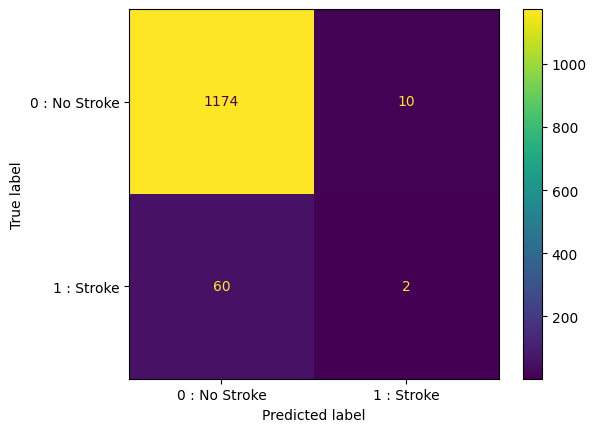

In [153]:
# Plotting the Confusion Matrix for Imbalanced Data and LGBM
cf_mat_lgbm_imb = cm(y_test,lgbm_preds_imb,labels=[0,1])
disp_lgbm_imb = ConfusionMatrixDisplay(confusion_matrix=cf_mat_lgbm_imb,display_labels=["0 : No Stroke","1 : Stroke"])
disp_lgbm_imb.plot()

<h5> Although the model is working well for classifying the class 0 ( No Stroke ) instance , still the Precision , Recall and F1 score for class 1 is not good enough , this is due to the highly imbalanced data which is biased towards predicting class 0 , To improve this , we can apply various Imbalance handling algorithms.</h5>

# Applying Imbalance handling methods using Adaboost : 

<h2> 1. UnderSampling </h2>

In [154]:
# Seperating Instances of each class
cl_0_new1 = df[df['stroke'] == 0]
cl_1_new1 = df[df['stroke'] == 1]

# UnderSampling the Majority class (i.e , class 0)
cl_0_new1 = cl_0_new1.sample(cl_1_new1.shape[0])

In [155]:
"""Concatinating the undersampled class 0 and original class 1 data and creating new Undersampled dataset having
 equal number of instances in each class (i.e , 248 instances for both classes)"""

new_df1 = pd.concat([cl_0_new1,cl_1_new1],axis=0)

In [156]:
# Splitting Data into Training and Testing sets
x_data1 = new_df1.drop(columns=['stroke'])
y_data1 = new_df1['stroke']

x_train1,x_test1,y_train1,y_test1  = train_test_split(x_data1,y_data1,random_state=42,stratify=y_data1)

In [157]:
# Applying Adaboost on this Undersampled Dataset
Ada_under_1 = AdaBoostClassifier(random_state=100)
Ada_under_1.fit(x_train1,y_train1)

AdaBoostClassifier(random_state=100)

In [158]:
# Predicting the test Instances
y_preds_under1 = Ada_under_1.predict(x_test1)

In [159]:
# Classification report 
print(classification_report(y_true=y_test1,y_pred=y_preds_under1,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       0.84      0.69      0.76        62
   1 : Stroke       0.74      0.87      0.80        62

     accuracy                           0.78       124
    macro avg       0.79      0.78      0.78       124
 weighted avg       0.79      0.78      0.78       124



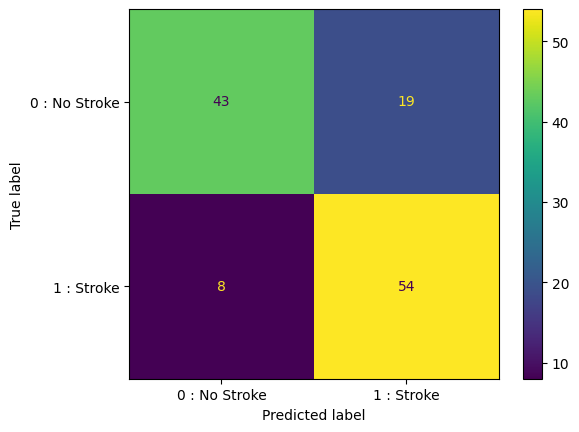

In [160]:
# Plotting the Confusion Matrix for UnderSampled Data and Adaboost
cf_mat_under = cm(y_test1,y_preds_under1,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat_under,display_labels=["0 : No Stroke","1 : Stroke"])
disp.plot()

<h2> 2. OverSampling </h2> 

In [161]:
# Seperating Instances of each class
cl_0_new2 = df[df['stroke'] == 0]
cl_1_new2 = df[df['stroke'] == 1]

# OverSampling the Minority class (i.e , class 1)
cl_new_1 = cl_1_new2.sample(cl_0_new2.shape[0],replace=True)

In [162]:
"""Concatinating the oversampled class 1 and original class 0 data and creating new Oversampled dataset having
   equal number of instances in each class (i.e , 4,733 instances for both classes)"""
new_df2 = pd.concat([cl_0_new2,cl_new_1],axis=0)

In [163]:
# Splitting Data into Training and Testing sets
x_data2 = new_df2.drop(columns=['stroke'])
y_data2 = new_df2['stroke']

x_train2,x_test2,y_train2,y_test2  = train_test_split(x_data2,y_data2,random_state=42,stratify=y_data2)

In [164]:
# Applying Adaboost on this Oversampled Dataset
Ada_over_1 = AdaBoostClassifier(random_state=100)
Ada_over_1.fit(x_train2,y_train2)

AdaBoostClassifier(random_state=100)

In [165]:
# Predicting the test Instances
y_preds_over1 = Ada_over_1.predict(x_test2)

In [166]:
# Classification report 
print(classification_report(y_true=y_test2,y_pred=y_preds_over1,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       0.85      0.74      0.79      1184
   1 : Stroke       0.77      0.87      0.82      1183

     accuracy                           0.81      2367
    macro avg       0.81      0.81      0.80      2367
 weighted avg       0.81      0.81      0.80      2367



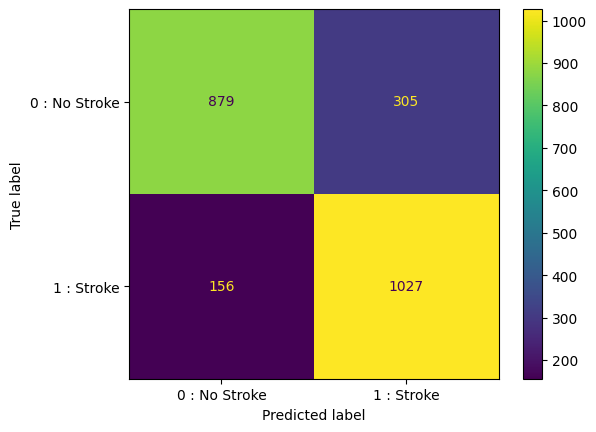

In [167]:
# Plotting the Confusion Matrix for OverSampled Data and Adaboost
cf_mat_over = cm(y_test2,y_preds_over1,labels=[0,1])
disp_over = ConfusionMatrixDisplay(confusion_matrix=cf_mat_over,display_labels=["0 : No Stroke","1 : Stroke"])
disp_over.plot()

<h2> 3. Synthetic Minority Oversampling Technique (SMOTE) </h2>

In [168]:
# Creating Sythetic data for the Minority Class (i.e , Class 1) and making instances in both classes = 4733
smote_over = SMOTE(sampling_strategy='minority')
x_syn , y_syn = smote_over.fit_resample(x_data,y_data)

In [169]:
# Splitting data into training and testing sets
x_train_syn , x_test_syn , y_train_syn , y_test_syn = train_test_split(x_syn,y_syn,random_state=42,stratify=y_syn)

In [170]:
# Applying Adaboost on this Synthetic sampled Dataset

Ada_syn_over = AdaBoostClassifier(random_state=100)
Ada_syn_over.fit(x_train_syn,y_train_syn)

AdaBoostClassifier(random_state=100)

In [171]:
# Predicting the test Instances
y_preds_syn = Ada_syn_over.predict(x_test_syn)

In [172]:
# Classification report 
print(classification_report(y_true=y_test_syn,y_pred=y_preds_syn,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       0.86      0.75      0.80      1184
   1 : Stroke       0.78      0.87      0.82      1183

     accuracy                           0.81      2367
    macro avg       0.82      0.81      0.81      2367
 weighted avg       0.82      0.81      0.81      2367



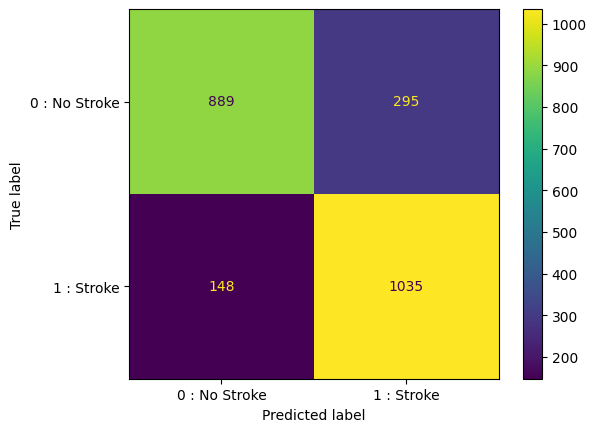

In [173]:
# Plotting the Confusion Matrix for Synthetic Sampled Data and Adaboost
cf_mat_syn = cm(y_test_syn,y_preds_syn,labels=[0,1])
disp_syn = ConfusionMatrixDisplay(confusion_matrix=cf_mat_syn,display_labels=["0 : No Stroke","1 : Stroke"])
disp_syn.plot()

# Applying Imbalance handling methods using XGBoost : 

<h2>1. Under Sampling</h2>

In [174]:
# Applying XGBoost on this Undersampled Dataset
XGB_under = XGBClassifier(random_state = 2)
XGB_under.fit(x_train1,y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=2, ...)

In [175]:
# Predicting the test Instances
XGB_under_preds = XGB_under.predict(x_test1)

In [176]:
# Classification report 
print(classification_report(y_true=y_test1,y_pred=XGB_under_preds,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       0.84      0.69      0.76        62
   1 : Stroke       0.74      0.87      0.80        62

     accuracy                           0.78       124
    macro avg       0.79      0.78      0.78       124
 weighted avg       0.79      0.78      0.78       124



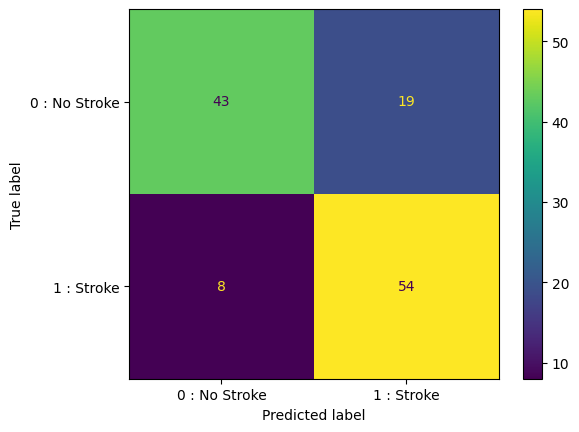

In [177]:
# Plotting the Confusion Matrix for Under Sampled Data and XGBoost
cf_mat_under2 = cm(y_test1,XGB_under_preds,labels=[0,1])
disp_under2 = ConfusionMatrixDisplay(confusion_matrix=cf_mat_under2,display_labels=["0 : No Stroke","1 : Stroke"])
disp_under2.plot()

<h2>2. OverSampling </h2>

In [178]:
# Applying XGBoost on this Oversampled Dataset
XGB_over = XGBClassifier(random_state = 42)
XGB_over.fit(x_train2,y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [179]:
# Predicting the test Instances
XGB_over_preds = XGB_over.predict(x_test2)

In [180]:
# Classification report 
print(classification_report(y_true=y_test2,y_pred=XGB_over_preds,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       1.00      0.95      0.97      1184
   1 : Stroke       0.95      1.00      0.98      1183

     accuracy                           0.98      2367
    macro avg       0.98      0.98      0.98      2367
 weighted avg       0.98      0.98      0.98      2367



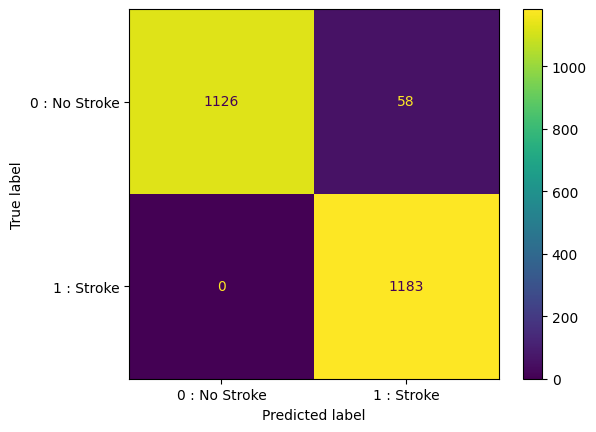

In [181]:
# Plotting the Confusion Matrix for OverSampled Data and XGBoost
cf_mat_over2 = cm(y_test2,XGB_over_preds,labels=[0,1])
disp_over2 = ConfusionMatrixDisplay(confusion_matrix=cf_mat_over2,display_labels=["0 : No Stroke","1 : Stroke"])
disp_over2.plot()

In [183]:
cnt = 0
cnt2 = 0
for i in range(len(XGB_over_preds)):
    if (XGB_over_preds[i] == 1 and np.array(y_test2)[i] == 0):
        cnt+=1
    if (XGB_over_preds[i] == 0 and np.array(y_test2)[i] == 1):
        cnt2+=1

In [213]:
print("No Stroke Instances Predicted as Stroke (Out of 1,183 test instances)   : ",cnt)
print("Stroke Instances Predicted as No Stroke (Out of 1,183 test instances)    : ",cnt2)
print("____________________________________________________________________________________")
print("")
print("Total Misclassified Instances (Out of 2,366 test instances)          : ", cnt+cnt2)
print("____________________________________________________________________________________")

No Stroke Instances Predicted as Stroke (Out of 1,183 test instances)   :  58
Stroke Instances Predicted as No Stroke (Out of 1,183 test instances)    :  0
____________________________________________________________________________________

Total Misclassified Instances (Out of 2,366 test instances)          :  58
____________________________________________________________________________________


<h2> 3. Synthetic Minority Oversampling Technique (SMOTE) </h2>

In [185]:
# Applying XGBoost on this Synthetic sampled Dataset

XGB_smote = XGBClassifier(random_state = 2)
XGB_smote.fit(x_train_syn,y_train_syn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=2, ...)

In [186]:
# Predicting the test Instances
XGB_syn_preds = XGB_smote.predict(x_test_syn)

In [187]:
# Classification report
print(classification_report(y_true=y_test_syn,y_pred=XGB_syn_preds,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       0.95      0.98      0.97      1184
   1 : Stroke       0.98      0.95      0.97      1183

     accuracy                           0.97      2367
    macro avg       0.97      0.97      0.97      2367
 weighted avg       0.97      0.97      0.97      2367



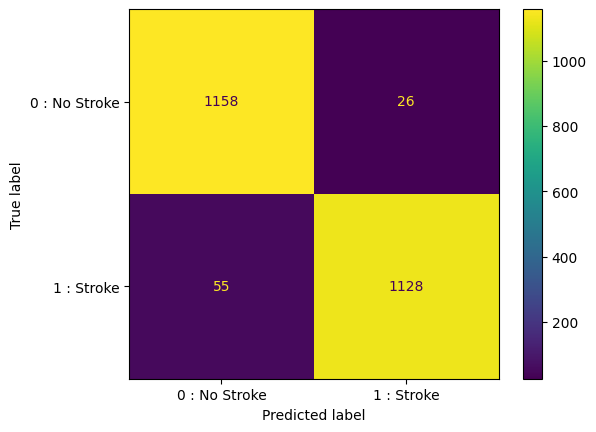

In [188]:
# Plotting the Confusion Matrix for Synthetic Sampled Data and XGBoost
cf_mat_syn2 = cm(y_test_syn,XGB_syn_preds,labels=[0,1])
disp_syn2 = ConfusionMatrixDisplay(confusion_matrix=cf_mat_syn2,display_labels=["0 : No Stroke","1 : Stroke"])
disp_syn2.plot()

# Applying Imbalance handling methods using LGBM : 

<h2>1. Under Sampling</h2>

In [189]:
# Making LGBM data (Under Sampled)
params = {'num_leaves':50}
train_data_under = lightgbm.Dataset(x_train1,label=y_train1)
test_data_under = lightgbm.Dataset(x_test1,label=y_test1)

In [190]:
# Training LGBM model on this under sampled Data
LGBM_under = lightgbm.train(params,train_data_under)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 10
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [191]:
# Making Predictions of test instances 
LGBM_under_preds = LGBM_under.predict(x_test1)

In [192]:
# Converting Decimal values to nearest class
lgbm_preds_under_fin = []
for i in LGBM_under_preds:
    if i <= 0.5:
        lgbm_preds_under_fin.append(0)
    else:
        lgbm_preds_under_fin.append(1)

In [193]:
# Classification report
print(classification_report(y_true=y_test1,y_pred=lgbm_preds_under_fin,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       0.82      0.73      0.77        62
   1 : Stroke       0.75      0.84      0.79        62

     accuracy                           0.78       124
    macro avg       0.79      0.78      0.78       124
 weighted avg       0.79      0.78      0.78       124



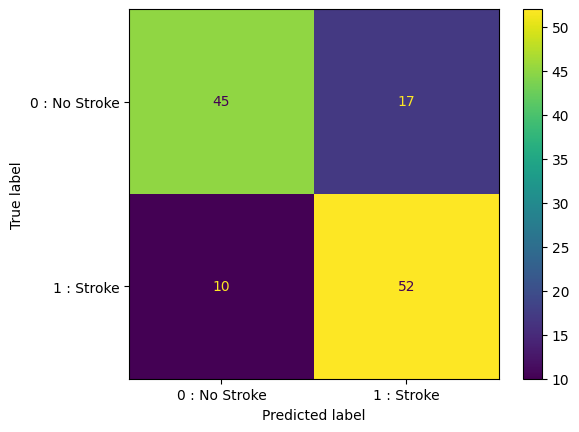

In [194]:
# Plotting the Confusion Matrix for underSampled Data and LGBM 
cf_mat_under3 = cm(y_test1,lgbm_preds_under_fin,labels=[0,1])
disp_under3 = ConfusionMatrixDisplay(confusion_matrix=cf_mat_under3,display_labels=["0 : No Stroke","1 : Stroke"])
disp_under3.plot()

<h2>2. OverSampling </h2>

In [195]:
# Making LGBM data (Over Sampled)
params = {'num_leaves':50}
train_data_over = lightgbm.Dataset(x_train2,label=y_train2)
test_data_over = lightgbm.Dataset(x_test2,label=y_test2)

In [196]:
# Training LGBM model on this Over sampled Data
LGBM_over = lightgbm.train(params,train_data_over)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 7099, number of used features: 10
[LightGBM] [Info] Start training from score 0.500070


In [197]:
# Making Predictions of test instances 
LGBM_over_preds = LGBM_over.predict(x_test2)

In [198]:
# Converting Decimal values to nearest class
lgbm_preds_over_fin = []
for i in LGBM_over_preds:
    if i <= 0.5:
        lgbm_preds_over_fin.append(0)
    else:
        lgbm_preds_over_fin.append(1)

In [199]:
# Classification report
print(classification_report(y_true=y_test2,y_pred=lgbm_preds_over_fin,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       1.00      0.93      0.96      1184
   1 : Stroke       0.93      1.00      0.96      1183

     accuracy                           0.96      2367
    macro avg       0.97      0.96      0.96      2367
 weighted avg       0.97      0.96      0.96      2367



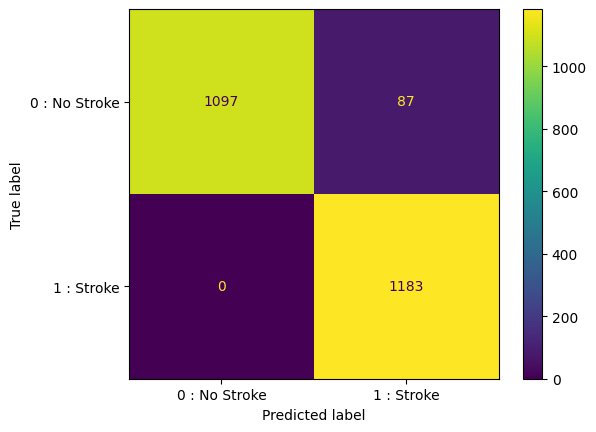

In [200]:
# Plotting the Confusion Matrix for OverSampled Data and LGBM 
cf_mat_over3 = cm(y_test2,lgbm_preds_over_fin,labels=[0,1])
disp_over3 = ConfusionMatrixDisplay(confusion_matrix=cf_mat_over3,display_labels=["0 : No Stroke","1 : Stroke"])
disp_over3.plot()

In [201]:
cnt_lgbm = 0
cnt2_lgbm = 0
for i in range(len(lgbm_preds_over_fin)):
    if (lgbm_preds_over_fin[i] == 1 and np.array(y_test2)[i] == 0):
        cnt_lgbm+=1
    if (lgbm_preds_over_fin[i] == 0 and np.array(y_test2)[i] == 1):
        cnt2_lgbm+=1

In [214]:
print("No Stroke Instances Predicted as Stroke (Out of 1,183 test instances)   : ",cnt_lgbm)
print("Stroke Instances Predicted as No Stroke (Out of 1,183 test instances)    : ",cnt2_lgbm)
print("_____________________________________________________________________________________")
print("")
print("Total Misclassified test Instances (Out of 2,366 test instances)          : ", cnt_lgbm+cnt2_lgbm)
print("_____________________________________________________________________________________")

No Stroke Instances Predicted as Stroke (Out of 1,183 test instances)   :  87
Stroke Instances Predicted as No Stroke (Out of 1,183 test instances)    :  0
_____________________________________________________________________________________

Total Misclassified test Instances (Out of 2,366 test instances)          :  87
_____________________________________________________________________________________


<h2> 3. Synthetic Minority Oversampling Technique (SMOTE) </h2>

In [203]:
# Making LGBM data (Synthetic Sampled using SMOTE)
params = {'num_leaves':50}
train_data_syn = lightgbm.Dataset(x_train_syn,label=y_train_syn)
test_data_syn = lightgbm.Dataset(x_test_syn,label=y_test_syn)

In [204]:
# Training LGBM model on this Synthetic sampled Data
LGBM_syn = lightgbm.train(params,train_data_syn)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 7099, number of used features: 10
[LightGBM] [Info] Start training from score 0.500070


In [205]:
# Making Predictions of test instances 
LGBM_syn_preds = LGBM_syn.predict(x_test_syn)

In [206]:
# Converting Decimal values to nearest class
lgbm_preds_syn_fin = []
for i in LGBM_syn_preds:
    if i <= 0.5:
        lgbm_preds_syn_fin.append(0)
    else:
        lgbm_preds_syn_fin.append(1)

In [207]:
# Classification report
print(classification_report(y_true=y_test_syn,y_pred=lgbm_preds_syn_fin,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       0.93      0.98      0.95      1184
   1 : Stroke       0.98      0.93      0.95      1183

     accuracy                           0.95      2367
    macro avg       0.95      0.95      0.95      2367
 weighted avg       0.95      0.95      0.95      2367



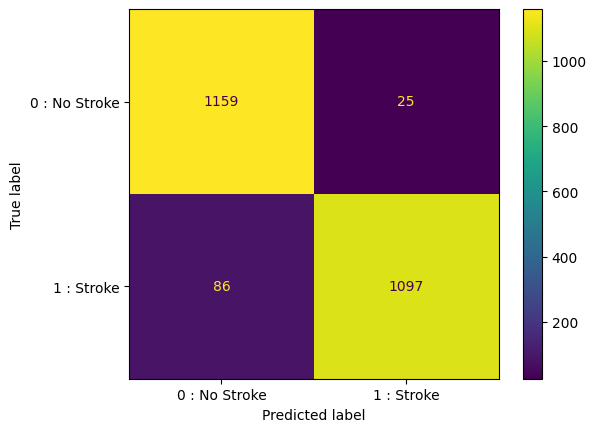

In [208]:
# Plotting the Confusion Matrix for Synthetic Sampled Data and LGBM 
cf_mat_syn3 = cm(y_test_syn,lgbm_preds_syn_fin,labels=[0,1])
disp_syn3 = ConfusionMatrixDisplay(confusion_matrix=cf_mat_syn3,display_labels=["0 : No Stroke","1 : Stroke"])
disp_syn3.plot()

# Plots for Performance on different model selections

In [235]:
#####    For AdaBoost     #####

f1_s_ada = []
ps_s_ada = []
rs_s_ada = []
acc_s_ada = []

f1_s_ada = [f1(y_test,y_preds),f1(y_test1,y_preds_under1),f1(y_test2,y_preds_over1),f1(y_test_syn,y_preds_syn)]
ps_s_ada = [ps(y_test,y_preds),ps(y_test1,y_preds_under1),ps(y_test2,y_preds_over1),ps(y_test_syn,y_preds_syn)]
rs_s_ada = [rs(y_test,y_preds),rs(y_test1,y_preds_under1),rs(y_test2,y_preds_over1),rs(y_test_syn,y_preds_syn)]
acc_s_ada = [acc(y_test,y_preds),acc(y_test1,y_preds_under1),acc(y_test2,y_preds_over1),acc(y_test_syn,y_preds_syn)]

f1_s_ada = np.round(np.array(f1_s_ada), 3)
ps_s_ada = np.round(np.array(ps_s_ada), 3)
rs_s_ada = np.round(np.array(rs_s_ada), 3)
acc_s_ada = np.round(np.array(acc_s_ada), 3)


In [236]:
#####    For XGBoost     #####

f1_s_xgb = []
ps_s_xgb = []
rs_s_xgb = []
acc_s_xgb = []

f1_s_xgb = [f1(y_test,y_preds_xgb),f1(y_test1,XGB_under_preds),f1(y_test2,XGB_over_preds),f1(y_test_syn,XGB_syn_preds)]
ps_s_xgb = [ps(y_test,y_preds_xgb),ps(y_test1,XGB_under_preds),ps(y_test2,XGB_over_preds),ps(y_test_syn,XGB_syn_preds)]
rs_s_xgb = [rs(y_test,y_preds_xgb),rs(y_test1,XGB_under_preds),rs(y_test2,XGB_over_preds),rs(y_test_syn,XGB_syn_preds)]
acc_s_xgb = [acc(y_test,y_preds_xgb),acc(y_test1,XGB_under_preds),acc(y_test2,XGB_over_preds),acc(y_test_syn,XGB_syn_preds)]

f1_s_xgb = np.round(np.array(f1_s_xgb), 3)
ps_s_xgb = np.round(np.array(ps_s_xgb), 3)
rs_s_xgb = np.round(np.array(rs_s_xgb), 3)
acc_s_xgb = np.round(np.array(acc_s_xgb), 3)


In [237]:
#####    For LGBM     #####

f1_s_lgbm = []
ps_s_lgbm = []
rs_s_lgbm = []
acc_s_lgbm = []

f1_s_lgbm = [f1(y_test,lgbm_preds_imb),f1(y_test1,lgbm_preds_under_fin),f1(y_test2,lgbm_preds_over_fin),f1(y_test_syn,lgbm_preds_syn_fin)]
ps_s_lgbm = [ps(y_test,lgbm_preds_imb),ps(y_test1,lgbm_preds_under_fin),ps(y_test2,lgbm_preds_over_fin),ps(y_test_syn,lgbm_preds_syn_fin)]
rs_s_lgbm = [rs(y_test,lgbm_preds_imb),rs(y_test1,lgbm_preds_under_fin),rs(y_test2,lgbm_preds_over_fin),rs(y_test_syn,lgbm_preds_syn_fin)]
acc_s_lgbm = [acc(y_test,lgbm_preds_imb),acc(y_test1,lgbm_preds_under_fin),acc(y_test2,lgbm_preds_over_fin),acc(y_test_syn,lgbm_preds_syn_fin)]

f1_s_lgbm = np.round(np.array(f1_s_lgbm), 3)
ps_s_lgbm = np.round(np.array(ps_s_lgbm), 3)
rs_s_lgbm = np.round(np.array(rs_s_lgbm), 3)
acc_s_lgbm = np.round(np.array(acc_s_lgbm), 3)


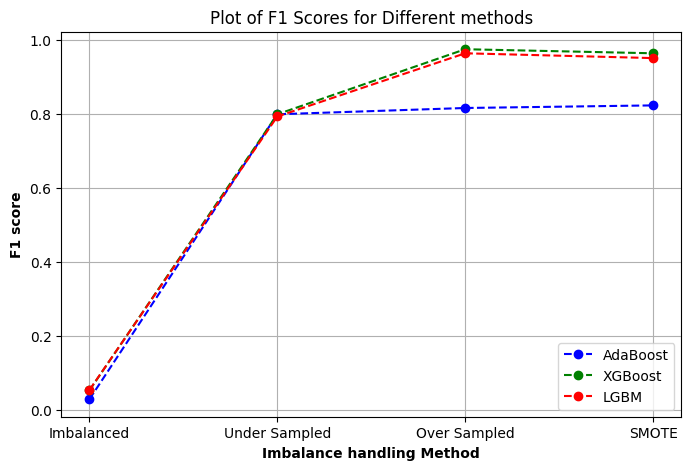

In [238]:
# Plot for F1 scores 

plt.figure(figsize = (8,5))
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],f1_s_ada,marker='o', linestyle='--',label = "AdaBoost",color='b')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],f1_s_xgb,marker='o', linestyle='--',label = "XGBoost",color = 'g')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],f1_s_lgbm,marker='o', linestyle='--',label = "LGBM",color = 'r')
plt.grid()
plt.title("Plot of F1 Scores for Different methods")
plt.xlabel("Imbalance handling Method",weight = 'bold')
plt.ylabel("F1 score",weight = 'bold')
plt.legend(loc='lower right')
plt.show()

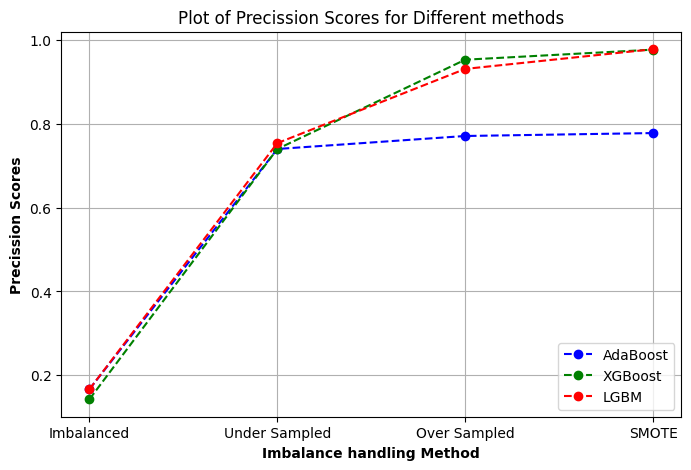

In [239]:
# Plot for Precision scores 

plt.figure(figsize = (8,5))
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],ps_s_ada,marker='o', linestyle='--',label = "AdaBoost",color='b')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],ps_s_xgb,marker='o', linestyle='--',label = "XGBoost",color = 'g')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],ps_s_lgbm,marker='o', linestyle='--',label = "LGBM",color = 'r')
plt.grid()
plt.title("Plot of Precission Scores for Different methods")
plt.xlabel("Imbalance handling Method",weight = 'bold')
plt.ylabel("Precission Scores",weight = 'bold')
plt.legend(loc='lower right')
plt.show()

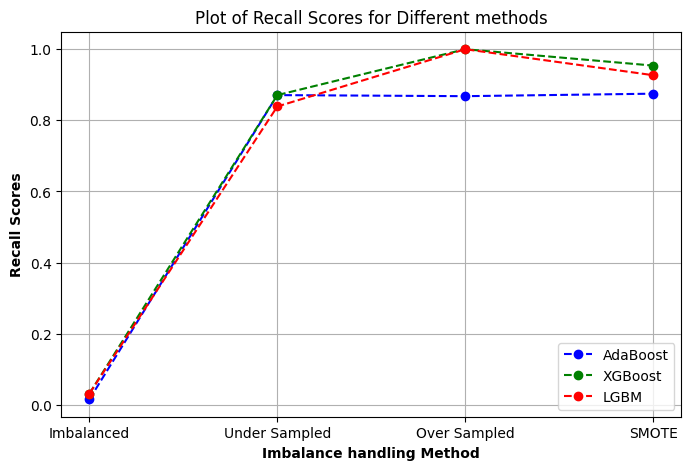

In [240]:
# Plot for Recall scores 

plt.figure(figsize = (8,5))
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],rs_s_ada,marker='o', linestyle='--',label = "AdaBoost",color='b')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],rs_s_xgb,marker='o', linestyle='--',label = "XGBoost",color = 'g')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],rs_s_lgbm,marker='o', linestyle='--',label = "LGBM",color = 'r')
plt.grid()
plt.title("Plot of Recall Scores for Different methods")
plt.xlabel("Imbalance handling Method",weight = 'bold')
plt.ylabel("Recall Scores",weight = 'bold')
plt.legend(loc='lower right')
plt.show()

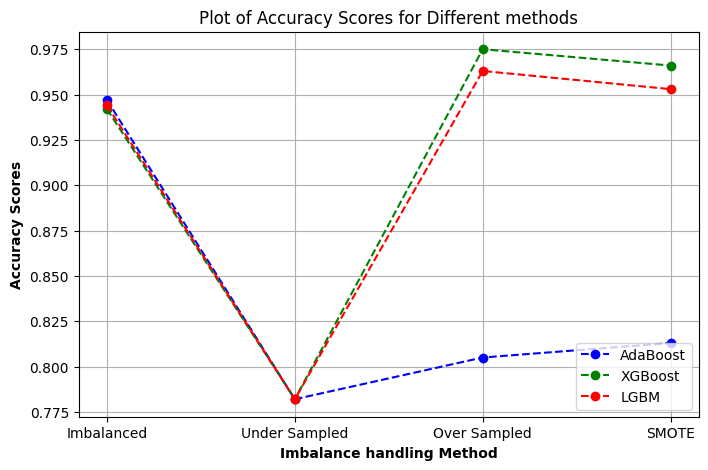

In [241]:
# Plot for Accuracy scores 

plt.figure(figsize = (8,5))
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],acc_s_ada,marker='o', linestyle='--',label = "AdaBoost",color='b')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],acc_s_xgb,marker='o', linestyle='--',label = "XGBoost",color = 'g')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],acc_s_lgbm,marker='o', linestyle='--',label = "LGBM",color = 'r')
plt.grid()
plt.title("Plot of Accuracy Scores for Different methods")
plt.xlabel("Imbalance handling Method",weight = 'bold')
plt.ylabel("Accuracy Scores",weight = 'bold')
plt.legend(loc='lower right')
plt.show()

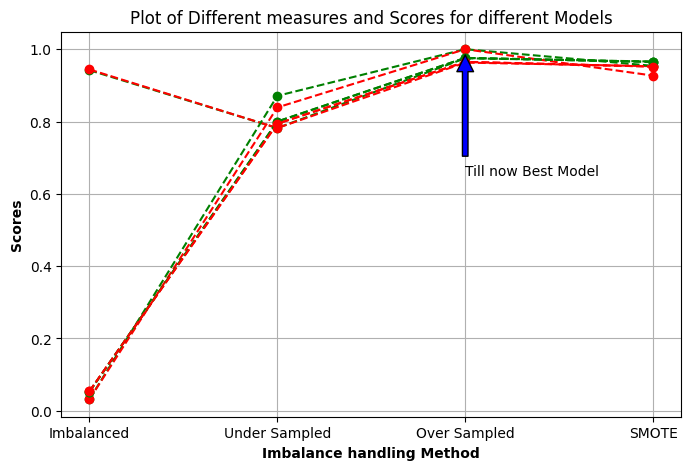

In [243]:
#Best model grapgh 

plt.figure(figsize = (8,5))
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],acc_s_xgb,marker='o', linestyle='--',label = "XGBoost",color = 'g')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],acc_s_lgbm,marker='o', linestyle='--',label = "LGBM",color = 'r')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],rs_s_xgb,marker='o', linestyle='--',label = "XGBoost",color = 'g')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],rs_s_lgbm,marker='o', linestyle='--',label = "LGBM",color = 'r')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],f1_s_xgb,marker='o', linestyle='--',label = "XGBoost",color = 'g')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],f1_s_lgbm,marker='o', linestyle='--',label = "LGBM",color = 'r')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],f1_s_xgb,marker='o', linestyle='--',label = "XGBoost",color = 'g')
plt.plot(["Imbalanced","Under Sampled","Over Sampled","SMOTE"],f1_s_lgbm,marker='o', linestyle='--',label = "LGBM",color = 'r')
plt.grid()
plt.title("Plot of Different measures and Scores for different Models")
plt.xlabel("Imbalance handling Method",weight = 'bold')
plt.ylabel("Scores",weight = 'bold')
low_point  = ("Over Sampled",1)
high_point = ("SMOTE",1)
plt.annotate('Till now Best Model', xy=low_point, xytext=("Over Sampled",0.65),
             arrowprops=dict(facecolor='blue', shrink=0.05))
plt.show()

<h3> Till Now , we have tried various methods to handle the imbalance in the data and train a model which is well suited to predict the Minority Positive class ( Class 1 : Stroke )  </h3>

<h3>Till Now , the model which performed best is the XGBoost model with the randomly oversampled dataset. Still , it is misclassifying  some instance from the Majority Class ( Class 0 : No stroke ) , this could be due to the fact that the nature of the prediction problem and the dataset is in a way biased towards the Class 0 , but we have oversampled the minority class to make a ratio of 1:1 for both the classes. This somehow, giving more importance to the positive minority class but on the same hand supressing the majority nature of the majority class. </h3>

<h3>Hence , we will try to oversample the minority class plus the majority class as well, to put some more importance on the majority class as well </h3>

<h2> Our Own Sampling Method : ( Say, Tarun and Aryan Sampling Method ) :</h2>

<h3>Since, the original ratio of the Number of instance in the minority positive class ( Class 1 : Stroke ) and the Majority negative class ( Class 0 : No stroke ) is in the ratio 1 : 20 ( approx )</h3>
<h3> And ,in the above work we saw that the original ratio 1 : 20  is performing very bad by suppressing the minority class and the Balanced Oversampling method using the ratio ( 1 : 1 ), is supressing the majority nature of the Class 0 . Hence, we tried the ratios between these ratios and checked  that the ratio ( 1:7 ), performs best for the dataset. Hence training the model, with 1 : 7 ratio Oversampled data (which means oversample class 1 , 1 times and class 0 , 6 times (with replacement))</h3>

In [215]:
# Seperating Instances of each class
cl_0_new2 = df[df['stroke'] == 0]
cl_1_new2 = df[df['stroke'] == 1]

# OverSampling the Minority class (i.e , class 1 , 1 times ) and the Majority Class ( i.e class 0 , 6 times)
cl_new_1 = cl_1_new2.sample(cl_0_new2.shape[0],replace=True)
cl_new_000 = cl_0_new2.sample(cl_0_new2.shape[0]*6,replace=True)

In [217]:
"""Concatinating the oversampled class 1 and Oversampled class 0 data and creating new Oversampled dataset having
   1:7 ratio of these classes"""
new_df_final = pd.concat([cl_0_new2,cl_new_1,cl_new_000],axis=0)

In [218]:
# Splitting Data into Training and Testing sets
x_data_fin = new_df_final.drop(columns=['stroke'])
y_data_fin = new_df_final['stroke']

x_train_fin,x_test_fin,y_train_fin,y_test_fin  = train_test_split(x_data_fin,y_data_fin,random_state=42,stratify=y_data_fin)

In [219]:
# Applying XGBoost on this Oversampled Dataset
XGB_over_fin = XGBClassifier(random_state = 42)
XGB_over_fin.fit(x_train_fin,y_train_fin)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [220]:
# Predicting the test Instances
XGB_over_preds_fin = XGB_over_fin.predict(x_test_fin)

In [221]:
# Classification report 
print(classification_report(y_true=y_test_fin,y_pred=XGB_over_preds_fin,target_names=class_names))

               precision    recall  f1-score   support

0 : No Stroke       1.00      1.00      1.00      8283
   1 : Stroke       1.00      1.00      1.00      1183

     accuracy                           1.00      9466
    macro avg       1.00      1.00      1.00      9466
 weighted avg       1.00      1.00      1.00      9466



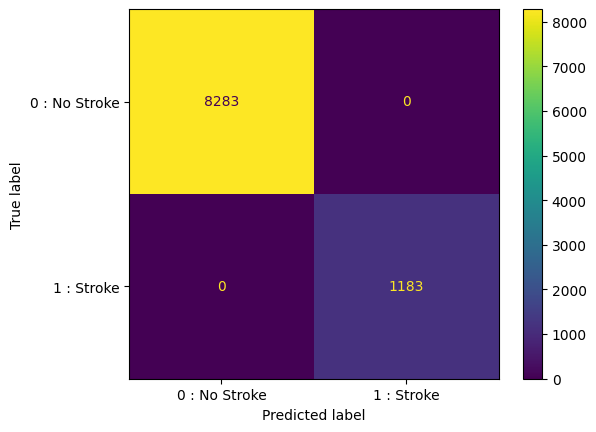

In [222]:
# Plotting the Confusion Matrix for OverSampled[1:7] Data and XGBoost
cf_mat_over_fin = cm(y_test_fin,XGB_over_preds_fin,labels=[0,1])
disp_over_fin = ConfusionMatrixDisplay(confusion_matrix=cf_mat_over_fin,display_labels=["0 : No Stroke","1 : Stroke"])
disp_over_fin.plot()

In [223]:
cnt = 0
cnt2 = 0
for i in range(len(XGB_over_preds_fin)):
    if (XGB_over_preds_fin[i] == 1 and np.array(y_test_fin)[i] == 0):
        cnt+=1
    if (XGB_over_preds_fin[i] == 0 and np.array(y_test_fin)[i] == 1):
        cnt2+=1

In [225]:
print("No Stroke Instances Predicted as Stroke (Out of 8,283 test instances)   : ",cnt)
print("Stroke Instances Predicted as No Stroke (Out of 1,183 test instances)    : ",cnt2)
print("____________________________________________________________________________________")
print("")
print("Total Misclassified Instances (Out of 9,466 test instances)          : ", cnt+cnt2)
print("____________________________________________________________________________________")

No Stroke Instances Predicted as Stroke (Out of 8,283 test instances)   :  0
Stroke Instances Predicted as No Stroke (Out of 1,183 test instances)    :  0
____________________________________________________________________________________

Total Misclassified Instances (Out of 9,466 test instances)          :  0
____________________________________________________________________________________


<h3>Finally Lets Try to predict the actual Data using our best model and check it's score on the actual data. </h3>

In [244]:
# From above steps , we got ( XGB_over_fin ) as the best model . 
best_model = XGB_over_fin

y_actual = y_data
y_best_predicted = best_model.predict(x_data)

In [245]:
# Checking the Classification report 
class_names = ["0 : No Stroke ","1 : Stroke "]
print(classification_report(y_true=y_actual,y_pred=y_best_predicted,target_names=class_names))

                precision    recall  f1-score   support

0 : No Stroke        1.00      1.00      1.00      4733
   1 : Stroke        1.00      1.00      1.00       248

      accuracy                           1.00      4981
     macro avg       1.00      1.00      1.00      4981
  weighted avg       1.00      1.00      1.00      4981



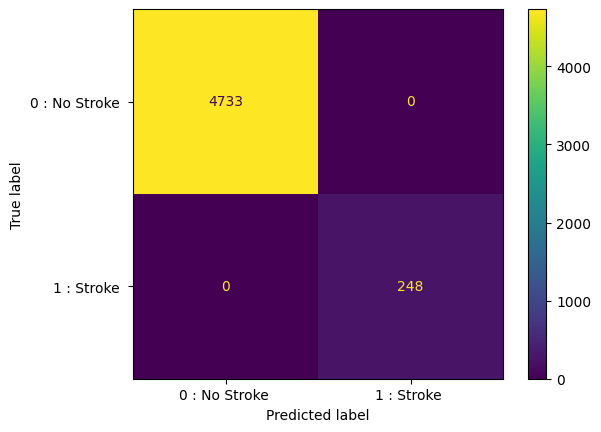

In [246]:
# Plotting the Confusion Matrix for Over All Original Data and Best Model (Oversampled[1:7] XGBoost)
act_data_cm = cm(y_actual,y_best_predicted,labels=[0,1])
disp_act_ = ConfusionMatrixDisplay(confusion_matrix=act_data_cm,display_labels=["0 : No Stroke ","1 : Stroke "])
disp_act_.plot()

In [247]:
cnt_best_model_actual_data = 0
cnt2_best_model_actual_data = 0
for i in range(len(y_best_predicted)):
    if (y_best_predicted[i] == 1 and np.array(y_actual)[i] == 0):
        cnt_best_model_actual_data+=1
    if (y_best_predicted[i] == 0 and np.array(y_actual)[i] == 1):
        cnt2_best_model_actual_data+=1

In [248]:
print("No stroke Instances Predicted as stroke (Out of 4,733 actual Instances)   : ",cnt_best_model_actual_data)
print("Stroke Instances Predicted as No stroke (Out of 248 actual Instances)   : ",cnt2_best_model_actual_data)
print("______________________________________________________________________________")
print("")
print("Total Misclassified Instances (Out of 4,981)          : ", cnt_best_model_actual_data+cnt2_best_model_actual_data)
print("______________________________________________________________________________")

No stroke Instances Predicted as stroke (Out of 4,733 actual Instances)   :  0
Stroke Instances Predicted as No stroke (Out of 248 actual Instances)   :  0
______________________________________________________________________________

Total Misclassified Instances (Out of 4,981)          :  0
______________________________________________________________________________


<h4> Our best trained model is correctly classifying all the Stroke and Non stroke instances of the actual data , hence  the model is not at all biased towards any of the classes , this can be seen from the fact that it performed the same on the test data for the Oversampled XGBoost, It did not classified any Stroke instances as Non stroke. So, every Stroke instance is caught with an accuracy of almost 100% and every Non Stroke instance is detected corectly with an accuracy of almost 100%</h4>